# Pancancer cis comparison of frequently mutated genes

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import cptac
import cptac.algorithms as al

In [2]:
def format_cis_comparison_data(cancer_object, specific_omics, gene):
    
    # Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop nan values
    omics_and_mutations = cancer_object.append_mutations_to_omics(
        mutation_genes = gene, omics_df_name = specific_omics.name, omics_genes = gene).dropna()

    # Check if values in omics data (if not found in proteomics, after na dropped dataframe should be empty)
    if omics_and_mutations[gene+"_"+specific_omics.name].empty:
        print('Not possible to do T-test. No data for', gene, 'in', specific_omics.name)
        return None
    else:
        
        # Step 2 - Create the binary column needed to do the comparison
        omics_and_mutations['binary_mutations'] = np.where(
            omics_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

        # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
        tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor']
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        omics_binary_mutations = tumors.drop(columns_to_drop, axis = 1)
        #check if only one column of omics data (total 2 columns)
        if len(omics_binary_mutations.columns) != 2:
            print('exeption with columns. check omics data')
            return None
        else:
            # Make a list of the column label of omics to be used in the wrap_ttest function
            omics_col_list = [omics_binary_mutations.columns[0]] 

            # Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
            print("Doing t-test comparison\n")
            significant_pval_results = al.wrap_ttest(omics_binary_mutations, 'binary_mutations', omics_col_list)
            print(significant_pval_results)

            formated_data_for_boxplot = {'data': omics_binary_mutations, 'x': "binary_mutations", 
                                         'y': gene+"_proteomics", 'pval': significant_pval_results}
            return formated_data_for_boxplot

  

In [38]:
def get_missence_truncation_comparison(cancer_object, specific_omics, gene):
    specific_omics = cancer_object.get_proteomics()
    #get omics data and tumors
    omics_and_mutations = cancer_object.append_mutations_to_omics(
                mutation_genes = gene, omics_df_name = specific_omics.name, omics_genes = gene).dropna()
    tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor']
    if omics_and_mutations[gene+"_"+specific_omics.name].empty:
        print('Not possible to do T-test. No data for', gene, 'in', specific_omics.name)
        return None
    else:
        somatic_mutations = cancer_object.get_mutations().reset_index()

        if cancer_object.get_cancer_type() == 'colon':
            missence_truncation_groups = {'frameshift substitution': 'T', 
                'frameshift deletion': 'T', 'frameshift insertion': 'T', 
                'stopgain': 'T', 'stoploss': 'T', 'nonsynonymous SNV': 'M',
                'nonframeshift insertion': 'M','nonframeshift deletion': 'M', 
                'nonframeshift substitution': 'M'}
        else: 
            missence_truncation_groups = {'In_Frame_Del': 'M', 'In_Frame_Ins': 'M',
                'Missense_Mutation': 'M', 'Frame_Shift_Del': 'T','Nonsense_Mutation': 'T', 
                'Splice_Site': 'T', 'Frame_Shift_Ins': 'T','Nonstop_Mutation':'T'}

        mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
        mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

        # group mutation categories
        miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'M']
        trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'T']

        #get lists of unique samples for missence and trucation categories
        miss_unique_samples = list(miss['Sample_ID'].unique())
        trunc_unique_samples = list(trunc['Sample_ID'].unique())

        #check if there is only one type of mutation for the specific gene
        if miss_unique_samples == []:
            print('Only truncation type mutations found for', gene+'.', 
                 'Not possible to compare mutation types.')
            return None
        elif trunc_unique_samples == []:
            print('Only missence type mutations found for', gene+'.', 
                 'Not possible to compare mutation types.')
            return None

        # Step 2 - Create the binary column needed to do the comparison
        # Get mutation catagories with omics data
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missence')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        binary_mut_omics = missence_omics.append(truncation_omics)

        # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

        # Make a list of the column label of omics to be used in the wrap_ttest function
        omics_col_list = [binary_mut_omics.columns[0]] 

        # Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
        print("Doing t-test comparison\n")
        significant_pval_results = al.wrap_ttest(binary_mut_omics, 'binary_mutations', omics_col_list)
        print(significant_pval_results)

        formated_data_for_boxplot = {'data': binary_mut_omics, 'x': "binary_mutations", 
                                     'y': gene+"_"+specific_omics.name, 'pval': significant_pval_results}
        return formated_data_for_boxplot


## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [4]:
en_object = cptac.Endometrial()
desired_cutoff = .1

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n', endometrial_freq_mut.head())

matting dataframes...linear data.....

Number of Frequently Mutated Genes: 232 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA12            0.147368      0.094737        0.073684
1  ABCA13            0.115789      0.105263        0.042105
2  ACVR2A            0.105263      0.010526        0.094737
3  ADGRG4            0.136842      0.126316        0.021053
4  ADGRV1            0.115789      0.094737        0.052632


## Step 3: Select a gene from the list of frequently mutated genes above

Set the gene to which of the above frequently mutated genes you want to examine. For example, if you want to look at the gene PTEN, change the cell below to say "gene = 'MUC16'"

In [5]:
gene = 'MUC16'

## Step 4: Select desired omics comparison

Select which type of omics you want to compare. If you want to compare proteomics data for the interacting proteins, uncomment the "omics = en.get_proteomics()" line, etc.

In [6]:
omics = en_object.get_proteomics()
#omics = en_object.get_transcriptomics()
#omics = en_object.get_phosphoproteomics()
#omics = en_object.get_acetylproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data function returns a dictionary with the data, x, and y names needed to plot the comparison.

In [7]:
data_for_comparison = format_cis_comparison_data(en_object, omics, gene)

Doing t-test comparison

         Comparison   P_Value
0  MUC16_proteomics  0.043761


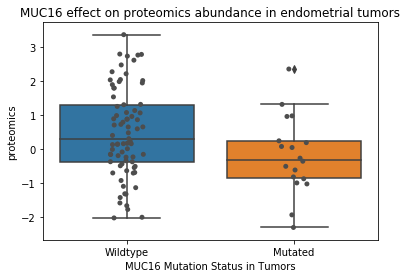

In [20]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
if data_for_comparison['data'] is not None:
    en_cis_boxplot = sns.boxplot(data = data_for_comparison['data'], x = data_for_comparison['x'],
                              y =data_for_comparison['y'], order = ["Wildtype","Mutated"])  
    en_cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance in endometrial tumors")
    en_cis_boxplot = sns.stripplot(data= data_for_comparison['data'], x = data_for_comparison['x'],
                                y = data_for_comparison['y'],jitter = True, color = ".3", order = ["Wildtype","Mutated"])
    en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = omics.name)
    plt.show()

Compare Missence and Truncation type mutations using the same proccess. This time we will use the get_missence_truncation_comparison function which also returns a dictionary with the p-value and data needed to make a boxplot

Doing t-test comparison

No significant comparisons.
None


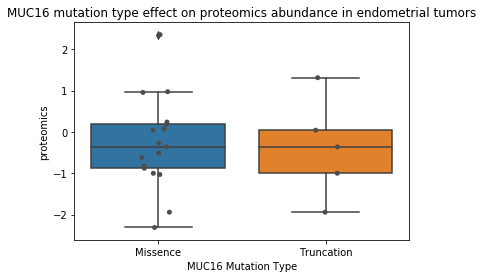

In [23]:
mutation_type_comparison = get_missence_truncation_comparison(en_object, omics, gene)

# Step 5 - Create boxplt to compare mutation type effect on omics data
if mutation_type_comparison['data'] is not None:
    en_cis_boxplot = sns.boxplot(data = mutation_type_comparison['data'], x = mutation_type_comparison['x'],
                              y =mutation_type_comparison['y'], order = ["Missence","Truncation"])  
    en_cis_boxplot.set_title(gene + " mutation type effect on " + omics.name + " abundance in endometrial tumors")
    en_cis_boxplot = sns.stripplot(data= mutation_type_comparison['data'], x = mutation_type_comparison['x'],
                                y = mutation_type_comparison['y'],jitter = True, color = ".3", order = ["Missence","Truncation"])
    en_cis_boxplot.set(xlabel = gene + " Mutation Type", ylabel = omics.name)
    plt.show()

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [24]:
colon_object = cptac.Colon()
desired_cutoff = .1

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n', colon_freq_mut.head())

matting dataframes...data.....ata....

Number of Frequently Mutated Genes: 612 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA13            0.195876      0.164948        0.103093
1   ABCA2            0.175258      0.164948        0.030928
2   ABCA4            0.144330      0.082474        0.061856
3   ABCB4            0.134021      0.061856        0.072165
4   ABCB6            0.103093      0.061856        0.041237


In [25]:
gene = 'MUC16'

co_omics = colon_object.get_proteomics()
#co_omics = colon_object.get_transcriptomics()
#co_omics = colon_object.get_phosphoproteomics()
#co_omics = colon_object.get_acetylproteomics()

In [26]:
co_data_for_comparison = format_cis_comparison_data(colon_object, co_omics, gene)

if co_data_for_comparison is not None:
    cis_boxplot = sns.boxplot(data = co_data_for_comparison['data'], x = co_data_for_comparison['x'],
                              y = co_data_for_comparison['y'], order = ["Wildtype","Mutated"])  
    cis_boxplot.set_title(gene + " effect on cis " + omics.name + " abundance in colon tumors")
    cis_boxplot = sns.stripplot(data = co_data_for_comparison['data'], x = co_data_for_comparison['x'],
                                y = co_data_for_comparison['y'], jitter = True, color = ".3", 
                                order = ["Wildtype","Mutated"])
    cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = omincs.name)
    plt.show()


MUC16 did not match any columns in proteomics dataframe. MUC16_proteomics column inserted, but filled with NaN.
Not possible to do T-test. No data for MUC16 in proteomics


In [40]:
co_mutation_type_comparison = get_missence_truncation_comparison(colon_object, co_omics, gene)

if co_mutation_type_comparison is not None:
    cis_boxplot = sns.boxplot(data = co_mutation_type_comparison['data'], x = co_mutation_type_comparison['x'],
                              y = co_mutation_type_comparison['y'], order = ["Wildtype","Mutated"])  
    cis_boxplot.set_title(gene + " effect on cis " + omics.name + " abundance in colon tumors")
    cis_boxplot = sns.stripplot(data = co_mutation_type_comparison['data'], x = co_mutation_type_comparison['x'],
                                y = co_mutation_type_comparison['y'], jitter = True, color = ".3", 
                                order = ["Wildtype","Mutated"])
    cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
    plt.show()

MUC16 did not match any columns in proteomics dataframe. MUC16_proteomics column inserted, but filled with NaN.
Not possible to do T-test. No data for MUC16 in proteomics


# Repeat with the Ovarian dataset


In [29]:
ovarian_object = cptac.Ovarian()
desired_cutoff = .1

ovarian_freq_mut = al.get_frequently_mutated(ovarian_object, cutoff=desired_cutoff)

In [30]:
gene = 'MUC16'

ov_omics = ovarian_object.get_proteomics()
#ov_omics = ovarian_object.get_transcriptomics()
#ov_omics = ovarian_object.get_phosphoproteomics()
#ov_omics = ovarian_object.get_acetylproteomics()

Doing t-test comparison

No significant comparisons.
None


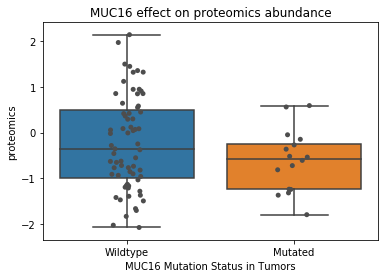

In [31]:
ov_data_for_comparison = format_cis_comparison_data(ovarian_object, ov_omics, gene)

if ov_data_for_comparison is not None:
    ov_cis_boxplot = sns.boxplot(data = ov_data_for_comparison['data'], x = ov_data_for_comparison['x'],
                              y = ov_data_for_comparison['y'], order = ["Wildtype","Mutated"])  
    ov_cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance")
    ov_cis_boxplot = sns.stripplot(
        data = ov_data_for_comparison['data'], x = ov_data_for_comparison['x'],y = ov_data_for_comparison['y'], 
        jitter = True, color = ".3", order = ["Wildtype","Mutated"])
    ov_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = omics.name)
    plt.show()


Doing t-test comparison

No significant comparisons.
None


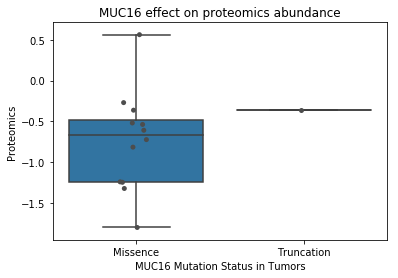

In [43]:
ov_mutation_type_comparison = get_missence_truncation_comparison(ovarian_object, ov_omics, gene)

if ov_mutation_type_comparison is not None:
    ov_cis_boxplot = sns.boxplot(data = ov_mutation_type_comparison['data'], x = ov_mutation_type_comparison['x'],
                              y = ov_mutation_type_comparison['y'], order = ["Missence","Truncation"])  
    ov_cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance")
    ov_cis_boxplot = sns.stripplot(
        data = ov_mutation_type_comparison['data'], x = ov_mutation_type_comparison['x'],y = ov_mutation_type_comparison['y'], 
        jitter = True, color = ".3", order = ["Missence","Truncation"]) 
    ov_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
    plt.show()

# Step 6: Compare cis effects between pancancer frequently mutated genes

Create a dataframe of the frequently mutated genes in common between Colon and Endometrial and Ovarian datasets. To compare two cancers uncomment the print statement with that comparison.

In [12]:
endometrial_genes = endometrial_freq_mut['Gene']
colon_genes = colon_freq_mut['Gene']
ovarian_genes = ovarian_freq_mut['Gene']


# Compare frequently mutated genes between Endometrial and Colon tumors
en_co_genes = pd.merge(endometrial_genes, colon_genes, how='inner')
#print('endometrial and colon commonly mutated genes:\n\n', en_co_genes['Gene'], '\n')

# Compare frequently mutated genes between Endometrial and Ovarian tumors
en_ov_genes = pd.merge(endometrial_genes, colon_genes, how='inner')
#print('endometrial and ovarian commonly mutated genes:\n\n', en_ov_genes['Gene'], '\n')

# Compare frequently mutated genes between Colon and Ovarian tumors
co_ov_genes = pd.merge(ovarian_genes, colon_genes, how='inner')
#print('colon and ovarian commonly mutated genes:\n\n', en_ov_genes['Gene'], '\n')

#Compare frequently mutated genes between all tumors
pancancer_commonly_mutated_genes = pd.merge(en_co_genes, ovarian_genes, how='inner')
print('pancancer frequently mutated genes:\n\n', pancancer_commonly_mutated_genes)

pancancer frequently mutated genes:

     Gene
0  MUC16
1  MUC17
2  MUC5B
3   TP53


Check significant difference in omics data between cancers. Pick a gene in common in the cancers you want to compare.